## SED Fitting with Prospector

A brief intro to SED modeling and using prospector. I cover two things in this tutorial: (1) basics of SED modeling that apply to any SED fitting code and (2) Bayesian inference (to the best of my ability). 

Before getting started, we need to install a few packages to run Prospector:

1. sedpy : this manages the details of our observations and allows us to interface with the properties of the photometric filters used. You can find sedpy here: https://github.com/bd-j/sedpy
2. dynesty : this is the backbone of propsector that handles the actual fitting methods. It is a form of Bayesian modeling similar to MCMC codes like 'emcee' but a bit more sophisticated. You can find dynesty here: https://github.com/joshspeagle/dynesty
3. fsps : this handles the stellar modeling for prospector. by itself, it's a super useful tool for generating stellar spectra. The core of fsps is a Fortran code but these days, the python bindings for fsps now come with its own fsps source code, meaning we no longer have to compile the Fortran code first then install the python wrapper. All we need is to clone the fortran fsps

                export SPS_HOME="/path/where/you/want/to/download/fsps"
                git clone https://github.com/cconroy20/fsps.git $SPS_HOME
                
And then pip install python-fsps

                python -m pip install fsps
                
4. Prospector : prospector is the tool that combines the above packages to model the SEDs of galaxies. You can find it here: https://github.com/bd-j/prospector 
It also has a pretty decent demo on how to use prospector: https://github.com/bd-j/prospector/blob/main/demo/InteractiveDemo.ipynb

For visualization purposes, we'll also want to install 2 packages: corner, which helps us plot corner plots (https://github.com/dfm/corner.py) and arviz, which allows us to do 'advanced' things with corner (conda install arviz) 


## step 1: what is SED fitting

SED modeling basically entails mapping the observed light of a galaxy at different wavelengths to their physical properties like stellar mass, star formation rate, and dust mass. There's a bunch of different codes that do this with varying levels of sophistication: FAST, CIGALE, MAGPHYS, ProSpect, Prospector, BAGPIPES, and many, many more. 

To model a galaxy spectrum and infer the galaxy's properties, there's a bunch of assumptions we have to make about how and when the stars formed in a galaxy (the star formation history), how much and what kind of dust is in that galaxy (dust attenuation and emisision), the properties of regions like HII nebulae and AGN. The figure below, pulled from Charlie Conroy's great review article on SED fitting, sums up the various components in SED modeling. For the purposes of this tutorial, we're going to focus on just the components pertaining to stars and dust. 

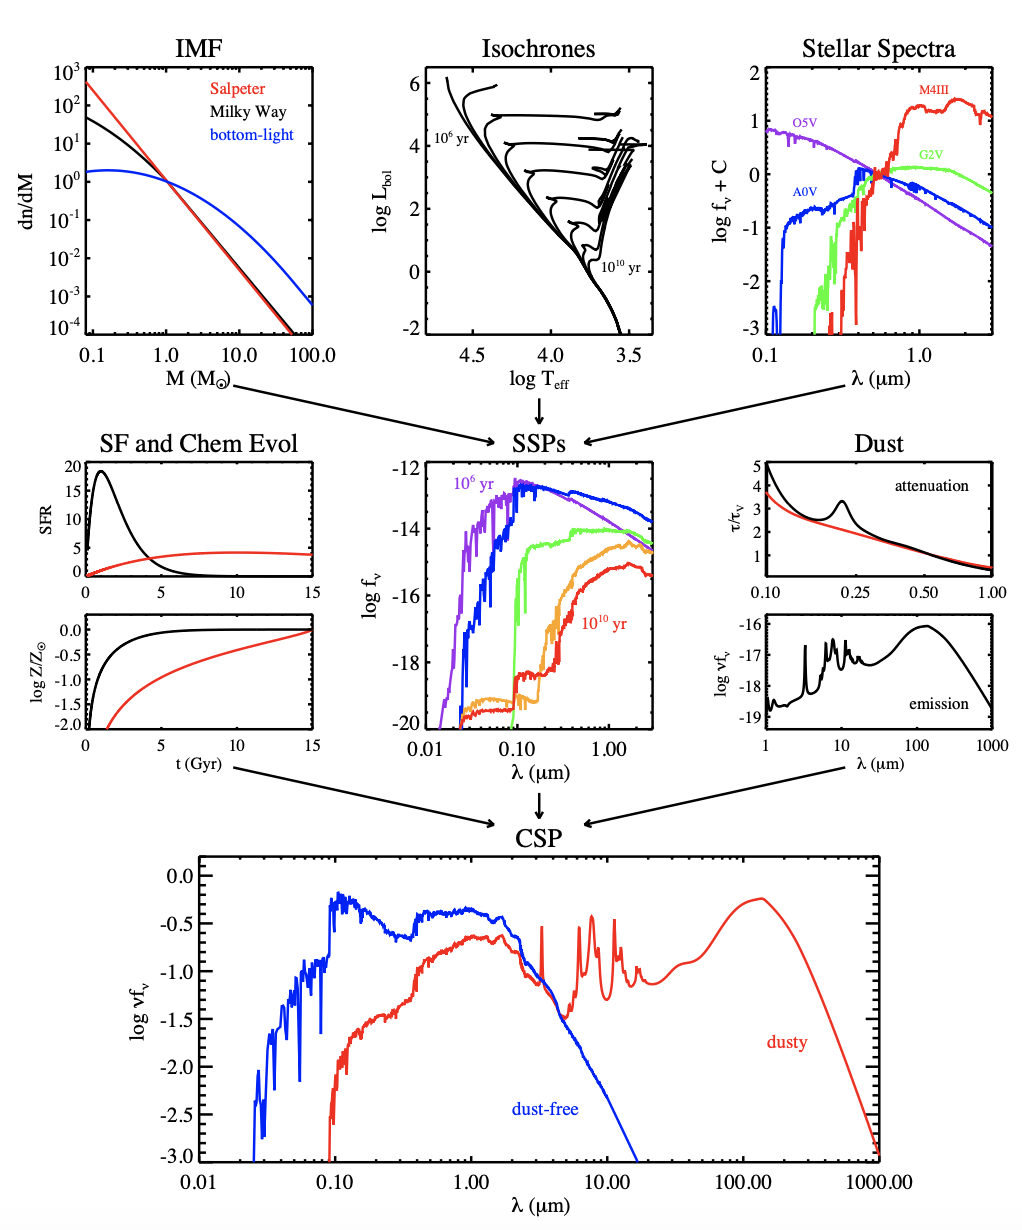



The top row concerns modeling stellar evolution. The IMF represents the stellar mass distribution of stars in a galaxy, literally how many stars of each mass are born in a galaxy -- there's a lot of debate over what the IMF is in various regions of our own Galaxy is but for our purposes, we just assume one of the typical distributions from the literature like Kroupa 2002 or Chabrier 2003. The isochrones are models detailing how stars move about the HR diagram as a function of time. Each line in that plot represents the distribution of stars for a fixed time. Stars that are born at the same time, but of different masses, will occupy different regions in color-magnitude space, impacting the colors of a galaxy. The right-hand plot shows spectra for a few different spectral types. Combine these three ingredients and we get something called a simple stellar population, or SSP, shown in the middle panel of the middle row. A simple stellar population represents the spectrum of a group of stars that are the same age. Think of it as taking a picture of a globular cluster: those stars formed at ~the same time but are of different masses and so the combined spectrum of that cluster will depend on how many high/low mass (hot/cold temp) stars there are and the age of that cluster. 

But a galaxy is definitely not just a globular cluster. It's more of a bunch of globular clusters of different ages put together. So how do we describe that spectrum? We combine it with a model for the star formation history of the galaxy -- literally, when did those globular clusters form? The left panel in the middle row shows two examples of a star formation history model (let's ignore the bottom plot showing metallicity). SFHs of real galaxies are diverse from galaxy-to-galaxy and have different short- and long-term variability. Convolving a model for SFH with an SSP gives us a compsite stellar spectrum combining the effects of stellar spectral types and stellar age. We can see an example of this spectrum in the blue curve plotted in the bottom row. 

Finally, to the shagrin of most UV and optical astronomers, a galaxy is not just stars, it also contains dust. Dust modulates the spectrum of a galaxy by absorbing the UV and optical light of stars and re-emitting that light as a blackbody in the far-infrared. This absorption (+ scattering) is called dust attenuation and is modeled with a dust attenuation curve. In the right panel of the middle row, we see an example of this where tau (optical depth) is plotted as a function of wavelength. Dust preferentially absorbs light (i.e., higher optical depths) in the UV and not as much in the red / near-IR. There's several features to a dust attenuation curve but for now, we'll stick with using one of the most commonly used attenuation curves in the literature: the Calzetti 2001 curve, which is shown in red in the plot. The plot right underneath shows the resulting dust emission spectra. Focusing on the peak of the curve around 100 micron, this spectrum is the result of the dust absorbing light in the UV, heating up, and re-emitting that light as a thermal blackbody. The weird features around 10 micron are the result of a special kind of dust called PAHs (polycyclic aromatic hydrocarbon) -- these are fascinating but we'll ignore them for now. The shape of the blackbody curve is dependent on the amount of dust and the dust temperature. 

Combining the two rows, we get a 'composite' galaxy spectra, including the contributions of stars of all ages and dust, shown in red in the bottom plot. This is the general shape of a galaxy SED: the stars dominate in the UV and optical while the dust emission dominates in the mid- to far-infrared. To extract information from a galaxy SED, we essentially do the above process backwards: what star and dust spectra are the best fit to the observed SED, from which we can derive the properties of the galaxy? To figure that out, we select models for the stellar evolution, star formation history, and dust. The stellar evolution models are typically fixed (i.e., we choose one model set and stick with it), but the parameters of the star formation history model and the dust attenuation/emission models can vary -- this represents the basis of our MCMC problem: what combination of model parameters give us a best fit to our data? To perform this fit, we'll use fsps+dynesty+prospector.

## step 2: how to fit data

The basic idea anytime we want to fit a model to data is to literally minimize the difference between the model and the data. In its most basic form, this means generating a model SED and calculating the chi square statistic, with the 'best fit' model having the lowest chi square. In a more sophisticated form, this involves Bayesian inference. I'm never going to do an explanaition of Bayesian statistics justice, so if you're super interested in learning the mechanics of this, I suggest doing outside readins. Regardless, the basis of Bayesian inference is that we have some 'prior' knowledge that we can use to construct the probability distribution of model parameters, which can in turn be used to construct a sort-of best fit model SED. Bayesian inference comes from Bayes theorem (which I'll point to the wiki page for more info: https://en.wikipedia.org/wiki/Bayes%27_theorem) which says the probability distribution of a model parameter (called the posterior distribution) is related to the likelihood of that model parameter * the prior distribution of that model parameter. If you've ever read a paper about model fitting or listened to a colloquium about deriving properties of something from a model, this is where 'prior,' 'posterior,' and 'likelihood' come from. 

What this means in practice is that for any set of models we choose for our SED components (star formation history, dust), the model SED is evaluated based on the prior knowledge of the distribution of model parameters and the likelihood of that model parameter representing the true data. For our purposes, the likelihood function is taken care of in the internals of prospector/dynesty. Thus for each (variable) model parameter, we will choose a prior distribution based on our knowledge of that parameter. Literally, what are the physical or known values this model parameter can take? An example is the age of a galaxy: we know that a galaxy has to have an age greater than zero and less than the age of the universe. Now, priors can have any degree of complexity but most of the time we will use an 'uninformative' prior, i.e., a prior that does not impose a lot of weight on the posterior distribution of the model paramter. An example of an uninformative prior is a uniform distribution, and for the age of the galaxy, the prior would range from 0 to 14 Gyr with every value in between having equal probability within the prior space. An example of an 'informative' prior would be a Gaussian, where galaxy ages around the mean of the Gaussian would have greater weight than ages close to the wings. Neither prior distribution is necessarily 'wrong,' (and believe me, there's tons of discussion on the intricacies of choosing priors) and generally is entirely dependent on the information/data we have and the problem we are trying to solve. 

Specifically for prospector, which we'll see below, we don't interface with the actual Bayesian inference at all, besides the initial selection of models and the choices for model priors. After the data has been fit, what we'll have as a result are posterior distributions for each model parameter. In cases where the data is not constraining or is not fit very well, these posterior distributions will resemble the prior distributions, basically a null result. But most of the time, we'll get back posterior distributions that resemble a Gaussian from which we can report the median value +/- the variability -- this is _usually_ what's reported in publications. From this point, we can discuss things like maximum likelihood estimates vs. medians and degeneracies but that's probably outside the scope of just getting started with prospector. 



## step 3: Demo

Here, we'll do two demos highlighting two particular types of star formation history models. We'll use an SED generated from Powderday for a galaxy from the Simba simulation as a way to get started with Prospector.

The first step of any SED modeling is to decide what models we are going to use to fit our data. As above, we'll just be focusing on things pertaining to stars and dust. 

The stellar modeling is entirely handled by fsps. In fact, when we installed fsps, the stellar isochrones and stellar spectra were already set to certain models/libraries by default. Though I could spend all day talking about how different stellar models impact SED fitting, we'll use these default models. The models we can control, however, are the star formation history, dust attenuation, and dust emission, which we'll spell out below. 

Prospector is really neat in that it's very modular. You basically hand over a function specifying all of your model choices, a function handing over your data, and a dictionary specifying things like # of MCMC walkers over to the prospector fitting function, which is just a wrapper of the dynesty fitting tools. Below I'll walk through the 'model' function and the 'sps' function. Then I'll point to a runtime script that combines everything together to fit SEDs with Prospector. 

Below is the build_model module, which as the name suggests is where we contruct our model that we will later use to fit data. The model consists of a SFH, dust attenuation, and dust emission, as well as things like the redshift, IMF, and metallicity. In this particular model example, we have chosen a "parametric" SFH, which assumes that the shape of the true SFH is similar to a declining exponential, like the black line in the above SFR plot. This model (which is choice 4 in fsps, as you can see in the sfh parameter line) consists of two parameters: "tau," which controls how quickly or slowly the star formation declines, and "tage," which controls the age of the galaxy / when the peak of star formation occurs. The normalization of the SFH is controlled by the stellar "mass" parameter. 

In [22]:
from prospect.models import priors, transforms #helper functions for specifying priors
from prospect.models import sedmodel
def build_model(**kwargs):
    
    """
    Function to build model components for SFH and dust. 
    The model params are defined by their name, whether they are a free parameter
    their initial value, and their prior distribution if they are variable. The model 
    params are then fed to the prospector SedModel class
    
    All parameters except 'mass' correspond to fsps model parameters, the definitions of which you can find here:
    https://dfm.io/python-fsps/current/stellarpop_api/
    
    """
    
    model_params = []
    #luminosity distance of galaxy. for a z=0 simba galaxy, i typically just set this to be 10 pc
    model_params.append({'name': "lumdist", "N": 1, "isfree": False,"init": 1.0e-5,"units": "Mpc"})
    #IMF model which will be used by the simple stellar population model
    model_params.append({'name': 'imf_type', 'N': 1,'isfree': False,'init': 2, 'prior': None})
    #stellar mass of a galaxy -- what we're interested in! So we'll set it as a free parameter
    model_params.append({'name': 'mass', 'N': 1,'isfree': True, 'init': 1e10,'prior': priors.TopHat(mini=1e8, maxi=1e12)})
    #stellar metallicity, in units of log(Z/Z_sun)
    model_params.append({'name': 'logzsol', 'N': 1,'isfree': True,'init': -0.5,'prior': priors.TopHat(mini=-1.6, maxi=0.1)})
    #SFH model. here, we are choosing the 'delayed-tau' model and has two free parameters: the age and the e-folding time
    model_params.append({'name': "sfh", "N": 1, "isfree": False, "init": 4, 'prior': None})
    #age of the galaxy
    model_params.append({'name': "tage", 'N': 1, 'isfree': True, 'init': 5., 'units': 'Gyr', 'prior': priors.TopHat(mini=0.001, maxi=13.8)})
    #e-folding time
    model_params.append({'name': "tau", 'N': 1, 'isfree': True,'init': 1., 'units': 'Gyr', 'prior': priors.LogUniform(mini=0.1, maxi=30)})
    #dust attenuation model, from Calzetti 2001
    model_params.append({'name': 'dust_type', 'N': 1,'isfree': False,'init': 2,'prior': None})
    #the attenuation (in magnitudes) in the V-band
    model_params.append({'name': 'dust2', 'N': 1,'isfree': True, 'init': 0.1,'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.0, sigma=0.3)})
    #dust emission model -- only 1 choice, from Draine & Li 2007
    model_params.append({'name': 'add_dust_emission', 'N': 1,'isfree': False,'init': 1,'prior': None})
    #mass fraction of warm dust
    model_params.append({'name': 'duste_gamma', 'N': 1,'isfree': True,'init': 0.01,'prior': priors.TopHat(mini=0.0, maxi=1.0)})
    #minimum radiation field
    model_params.append({'name': 'duste_umin', 'N': 1,'isfree': True,'init': 1.0,'prior': priors.TopHat(mini=0.1, maxi=20.0)})
    #mass fraction of dust in PAHs
    model_params.append({'name': 'duste_qpah', 'N': 1,'isfree': False,'init': 3.0,'prior': priors.TopHat(mini=0.0, maxi=6.0)})
    
    
    model = sedmodel.SedModel(model_params)
    return model





Above, we've set up our Prospector SED model, which includes the SFH, from which we can estimate the stellar mass and SFR, and dust attenuation and emission. Some of these parameters are free, indicated by "isfree=True" as in the "tage" parameter, which means those values will vary during the fit. Others are fixed during the fit, like the "imf_type" and "duste_qpah." When setting up your model, it's important to set everything up according to your specific problem/dataset (i.e., by changing around the parameter priors, including more or less free parameters, or changing the SFH or dust models). Below, we print out the model as setup above. This shows a summary of which models we've selected and which parameters are free and fixed.

In [18]:
mod = build_model()
print(mod)

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.TopHat'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-1.6,maxi=0.1)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  dust2: <class 'prospect.models.priors.ClippedNormal'>(mean=0.0,sigma=0.3,mini=0.0,maxi=2.0)
  duste_gamma: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=1.0)
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=20.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.1] 
  imf_type: [2] 
  sfh: [4] 
  dust_type: [2] 
  add_dust_emission: [1] 
  duste_qpah: [3.] 


Now we need to set up our FSPS object. This object controls the FSPS spectra generation (it's basically calling fsps.StellarPopulation but through the Prospector wrapper).

In [27]:
from prospect.sources import CSPSpecBasis
def build_sps(**kwargs):
    """
    This is our stellar population model which generates the spectra for stars of a given age and mass. 
    Most of the time, you aren't going to need to pay attention to this. 
    """
    sps = CSPSpecBasis(zcontinuous=1)
    return sps

In [28]:
sps = build_sps()

Now we can get our data sorted. We'll be testing on a z=0 galaxy from the simba simulation, loading in the Powderday SED. 

In [11]:
#convenience function for later
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

def build_obs(pd_dir, **kwargs):
    
    from sedpy.observate import load_filters
    from astropy import units as u
    from astropy import constants
    from astropy.cosmology import FlatLambdaCDM
    from hyperion.model import ModelOutput
    
    cosmo = FlatLambdaCDM(H0=68, Om0=0.3, Tcmb0=2.725)
    m = ModelOutput(pd_dir)
    wav, lum = m.get_sed(inclination=0,aperture=-1)
    wav  = np.asarray(wav)*u.micron                                                                                                                                    
    wav = wav.to(u.AA)
    lum = np.asarray(lum)*u.erg/u.s
    dl = (10*u.pc).to(u.cm) #setting luminosity distance to 10pc since we're at z=0
    flux = lum/(4.*3.14*dl**2.)
    nu = constants.c.cgs/(wav.to(u.cm))
    nu = nu.to(u.Hz)
    flux /= nu
    flux = flux.to(u.Jy)
    maggies = flux / 3631. 
    #don't ask me why, but Prospector expects your data to be in units of maggies
    #which thankfully is proportional to Janksys
    
    #OK, above is the raw Powderday SED. But what we want to hand Prospector is fake broadband or narrow band
    #photometry (unless we want to pretend the Powderday SED is a spectrum, which is possible). So below, we 
    #will sample photometry from the Powderday SED at a few filters from different instruments
    
    # these filter names / transmission data come from sedpy
    # it's super easy to add new filters to the database but for now we'll just rely on what sedpy already has
    jwst_nircam = ['jwst_f070w', 'jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 
                   'jwst_f277w', 'jwst_f356w', 'jwst_f444w']
    herschel_pacs = ['herschel_pacs_70', 'herschel_pacs_100', 'herschel_pacs_160']
    herschel_spire = ['herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500']
    filternames = (jwst_nircam + herschel_pacs + herschel_spire)
    
    filters_unsorted = load_filters(filternames)
    waves_unsorted = [x.wave_mean for x in filters_unsorted]
    filters = [x for _,x in sorted(zip(waves_unsorted,filters_unsorted))]
    
    flx = []
    flxe = []
    #redshifted_wav = wav*(1.+7.2) ---- if you are fitting a z>0 SED from Powderday, this is where
    #you would redshift those wavelengths. 
    for i in range(len(filters)):
        flux_range = []
        wav_range = []
        for j in filters[i].wavelength:
            flux_range.append(maggies[find_nearest(wav.value,j)].value)
            wav_range.append(wav[find_nearest(wav.value,j)].value)
        #convolving the Powderday SED with each filter transmission curve
        a = np.trapz(wav_range * filters[i].transmission * flux_range, wav_range, axis=-1)
        b = np.trapz(wav_range * filters[i].transmission, wav_range)
        flx.append(a/b)
        #and assuming a SNR of 30
        flxe.append(0.03* flx[i])
    flux_mag = np.asarray(flx)
    unc_mag = np.asarray(flxe)
    
    obs = {}
    #put some useful things in our dictionary. Prospector exepcts to see, at the least, the filters, photmetry
    #and errors, and if available, the spectrum information. I also include the full powderday SED for easy 
    #access later
    obs['filters'] = filters
    obs['maggies'] = flux_mag
    obs['maggies_unc'] = unc_mag
    obs['phot_mask'] = np.isfinite(flux_mag)
    obs['wavelength'] = None
    obs['spectrum'] = None
    obs['pd_sed'] = maggies
    obs['pd_wav'] = wav

    return obs

In [12]:
#let's get a look at our mock spectra / photometry
obs = build_obs('snap305.galaxy100.rtout.sed')

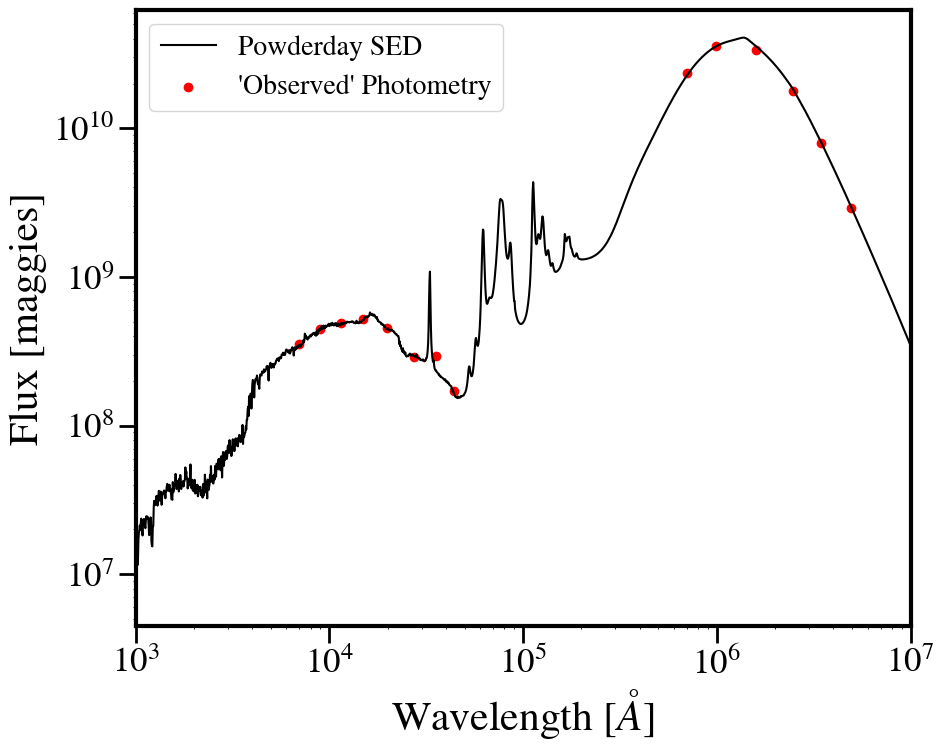

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    "savefig.facecolor": "w",
    "figure.facecolor" : 'w',
    "figure.figsize" : (10,8),
    "text.color": "k",
    "legend.fontsize" : 20,
    "font.size" : 30,
    "axes.edgecolor": "k",
    "axes.labelcolor": "k",
    "axes.linewidth": 3,
    "xtick.color": "k",
    "ytick.color": "k",
    "xtick.labelsize" : 25,
    "ytick.labelsize" : 25,
    "ytick.major.size" : 12,
    "xtick.major.size" : 12,
    "ytick.major.width" : 2,
    "xtick.major.width" : 2,
    "font.family": 'STIXGeneral',
    "mathtext.fontset" : "cm"
})


plt.loglog(obs['pd_wav'], obs['pd_sed'], color='black', label='Powderday SED')
plt.scatter([x.wave_mean for x in obs['filters']], obs['maggies'], color='red', label="'Observed' Photometry")
plt.xlim([1e3, 1e7])
plt.ylabel('Flux [maggies]')
plt.xlabel('Wavelength [$\AA$]')
plt.legend()
plt.show()

Now, time to fit our data with our model. To do this I've repackaged the above modules into a python script -- I definitely don't recommmend running in Jupyter or interactively on hipergator because the runtimes can be pretty long (~0.5-1 hour for the above fit to up to 24 hours for a fit with a more complex model). The runtime script is called "run_prosp_paraSFH.py" and contains the modules described above as well as the functions that actually call on prospector to run the fits. 

So assuming you've run the fit, let's visualize our results!

In [116]:
from prospect.io import read_results as pread
results, observations_dict, model = pread.results_from('galaxy_100_para_fit.h5')

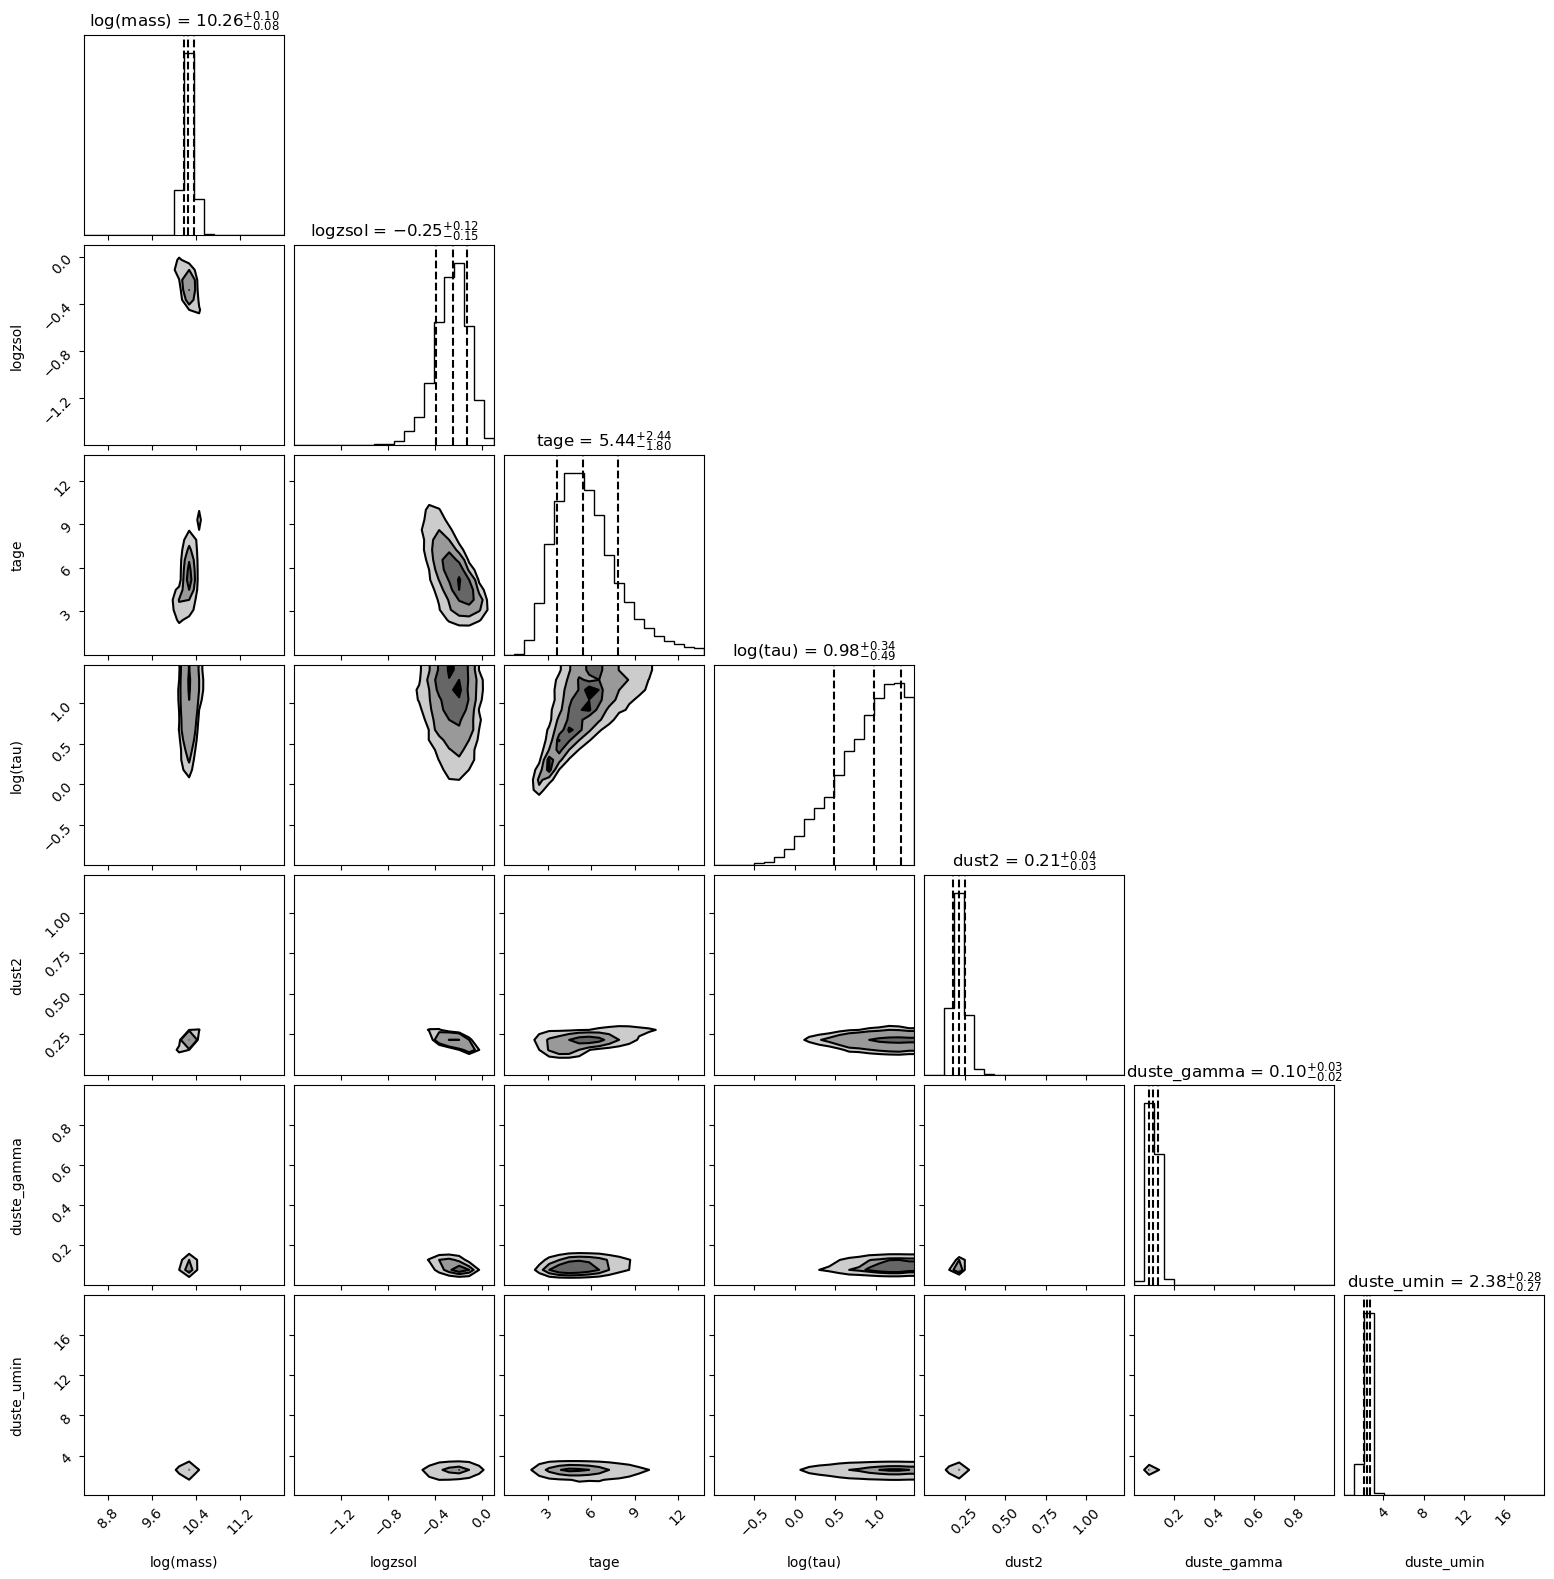

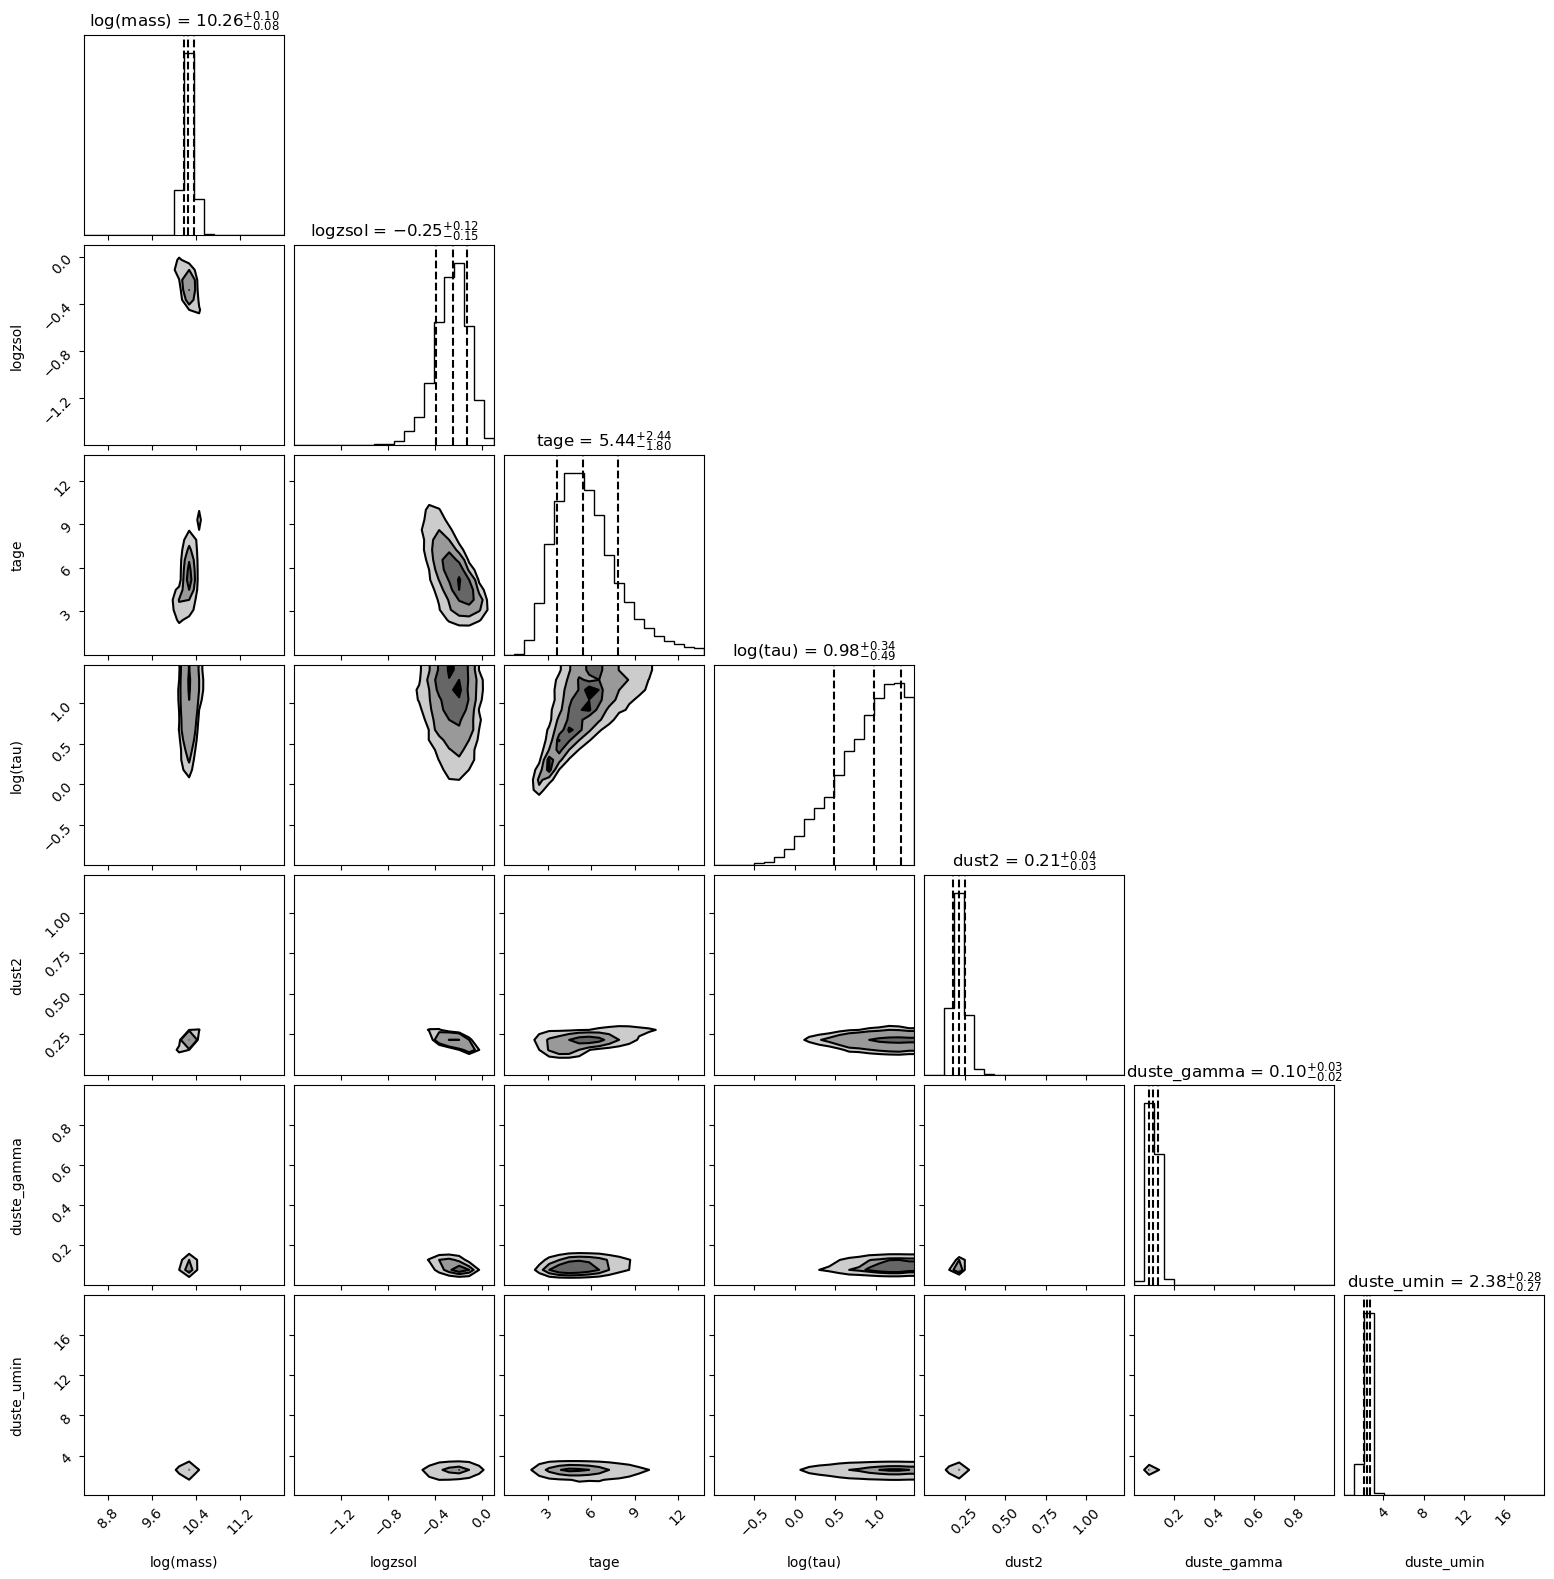

In [27]:
#First, let's take a look at the corner plot of our free parameters

pread.subcorner(results)

This is a corner plot, which is super useful to visualize the results of an MCMC fit. The histograms on the outside are called marginalized posterior distibutions - they show the posterior for a single model parameter independent of the other parameters. The inner 2D histograms show the 2D posterior distributions - these map the correlations / degeneracies between any two model parameters. 

Right off the bat, we can see that our stellar mass is pretty well constrained as well as the amount of diffuse dust attenuation (dust2). Other parameters like the timescale of star formation (tau) are not as well constrained. 

Let's take a closer look at the posterior distribution for the stellar mass:

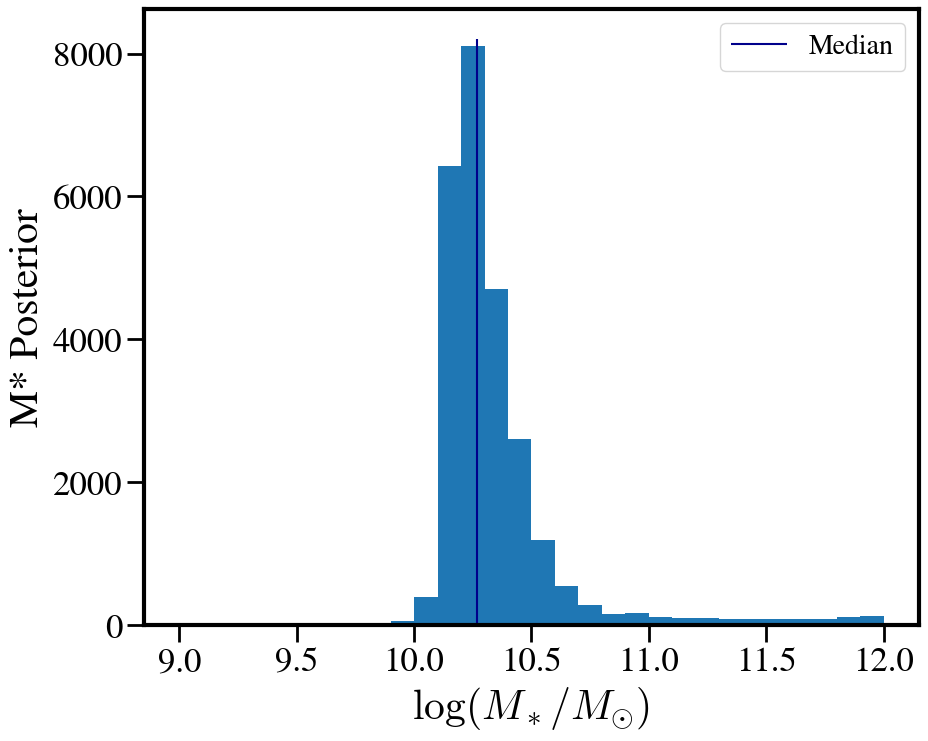

In [16]:
model_thetas = model.theta_labels()
stellar_mass = results['chain'][:,model_thetas.index('mass')] 
#the 'chain' arrays in our results refer to the samples drawn from the parameter prior distributions.
#we just pull out the stellar mass drawn from the prior for each iteration

n = plt.hist(np.log10(stellar_mass), range=(9, 12), bins=30)
plt.vlines(np.median(np.log10(stellar_mass)), ymin=0, ymax=np.max(n[0])+100, color='darkblue', label='Median')
plt.ylabel('M* Posterior')
plt.xlabel('$\log(M_* / M_{\odot})$')
plt.legend()

This posterior represents the area of prior space convolved with the likelihood that dynesty sampled, clearly showing a maximum likelihood peaking at ~2e10. 

## One major thing to take note of:
the mass returned from prospector is the sum of all the stellar massed formed according to the SFH. This is not the stellar mass that we would "observe," or the stellar mass that from the simba snapshot/caesar files. The difference between the two is the fraction of surviving stellar mass; as galaxies (stars) age, the most massive stars die off the quickest. So for instance, 10 Msun stars that were formed, according to the star formation history, 3 billion years ago will not be surviving to time of observation. This is taken into account by the stellar evolution models in fsps (controlled by the choice of stellar isochrones, IMF, etc.) So to get the real stellar mass estimate from prospector, we need to run those stellar evolution models that will tell us the surviving fraction of stellar mass:


In [30]:
#below, the "model.predict" call takes the parameter posteriors and generates the model SED and mass fraction
#that we can use to correct the integrated mass value above

#to speed things up since this function can take a while to generate all of those fsps spectra
#we can just sample the ~5000 most likely parameter values


from tqdm.auto import tqdm
seds_spec = []
seds_mag = []
surviving_mass_frac = []

weights = results.get('weights',None) #likelihood values
idx = np.argsort(weights)[-5000:] #select 5000 most likely

for i in tqdm(idx):
    thetas = results['chain'][i]
    spec, mags, mass_frac = model.predict(thetas,sps=sps,obs=observations_dict)
    seds_spec.append(spec)
    seds_mag.append(mags)
    surviving_mass_frac.append(mass_frac)
    
    
corrected_stellar_mass_posterior = results['chain'][idx,model_thetas.index('mass')] * np.array(surviving_mass_frac) 

  0%|          | 0/5000 [00:00<?, ?it/s]

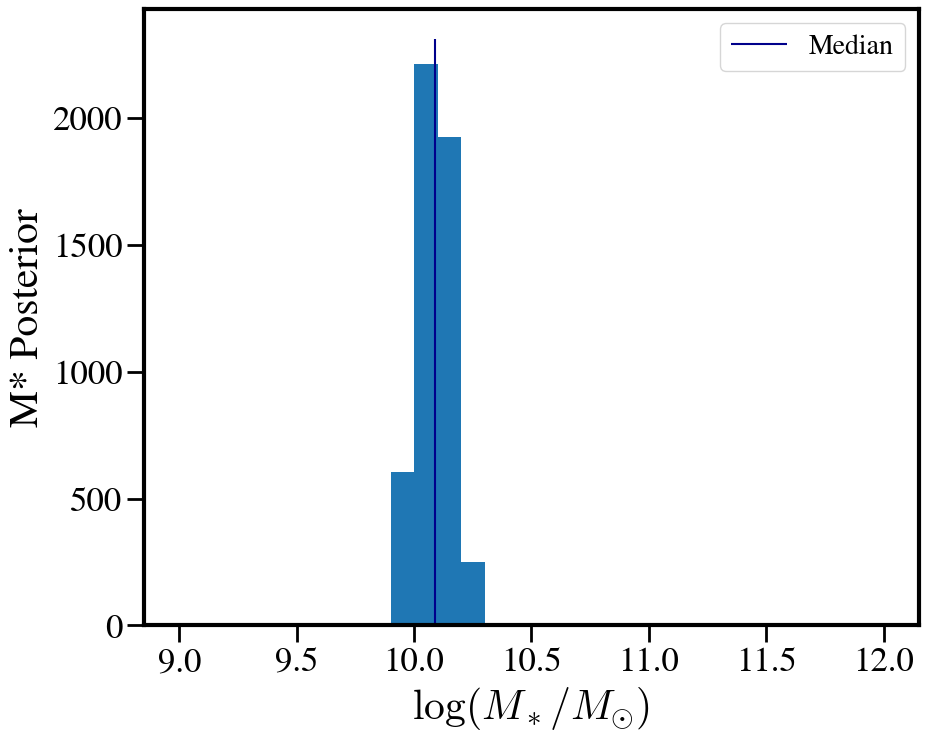

In [31]:
n = plt.hist(np.log10(corrected_stellar_mass_posterior), range=(9, 12), bins=30)
plt.vlines(np.median(np.log10(corrected_stellar_mass_posterior)), ymin=0, ymax=np.max(n[0])+100, color='darkblue', label='Median')
plt.ylabel('M* Posterior')
plt.xlabel('$\log(M_* / M_{\odot})$')
plt.legend()

Now our estimate for the galaxy's stellar mass is ~1.2e10. How does this compare to the real stellar mass from the caesar files? 

In [2]: obj = caesar.load('/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0305_z0.000.hdf5')

In [3]: obj.galaxies[100].masses['stellar']

1.56390241e+10, 'Msun'


... Close! About a factor of 1.3 too small, not bad for a ~simple SED fit. Speaking of, let's look at the SED posteriors:

In [32]:
from corner import quantile
sed_dist = []
for i in tqdm(range(len(sps.wavelengths))):
    sed_dist.append(quantile([item[i] for item in seds_spec], [0.16, 0.5, 0.84]))

  0%|          | 0/5994 [00:00<?, ?it/s]

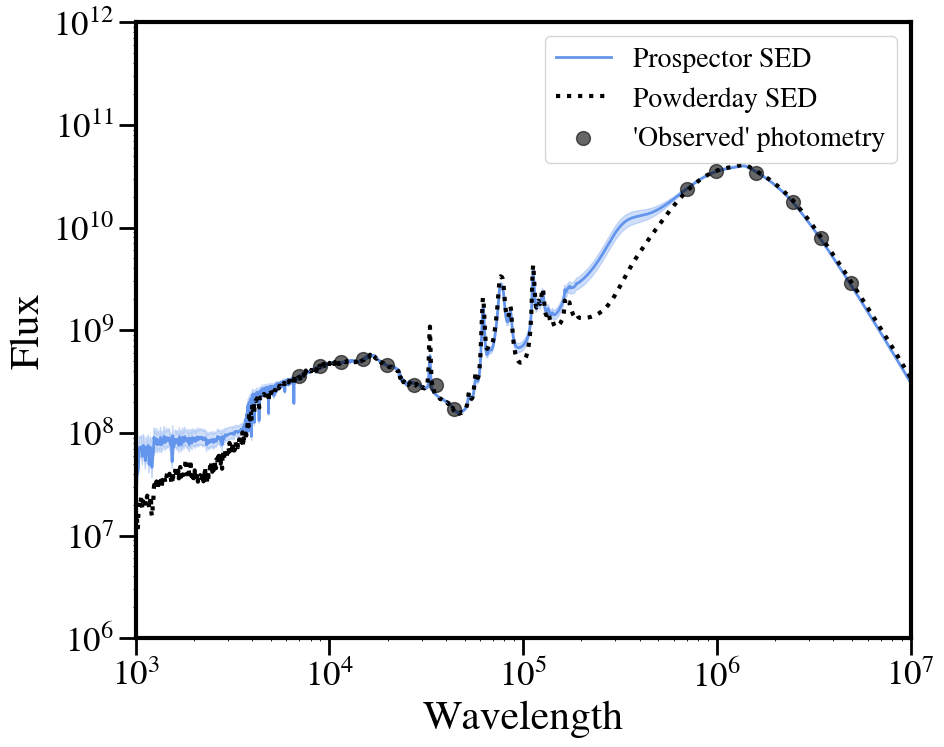

In [33]:
plt.figure(figsize=(10, 8))

plt.loglog(sps.wavelengths, [item[1] for item in sed_dist], color='cornflowerblue', lw=2, label='Prospector SED')
plt.fill_between(sps.wavelengths, [item[0] for item in sed_dist], [item[2] for item in sed_dist], color='cornflowerblue', alpha=0.3)

plt.plot(observations_dict['pd_wav'], observations_dict['pd_sed'], color='black', ls=':', lw=3, label='Powderday SED')
plt.scatter([x.wave_mean for x in observations_dict['filters']], observations_dict['maggies'], 
            color='black', marker='o', s=100, alpha=0.6,zorder=10, label="'Observed' photometry")
plt.xlim([1e3, 1e7])
plt.ylim([1e6, 1e12])
plt.ylabel('Flux')
plt.xlabel('Wavelength')
plt.legend()

Here, the distribution of inferred SEDs is shown in blue. The solid blue line is the median of the distribution while the shaded region are the 16-84th percentiles (which, for a gaussian distribution is 1 sigma). The parts of the SED where photometry was sampled are pretty well fit! But around 0.5 and 20 microns, the Prospector SED tends to over estimate the true SED.

## Nonparametric SFHs

In this section, we'll again be fitting that galaxy from the simba simulation but this time, we'll use a more sophisticated SFH model that will hopefully result in a stellar mass that's even closer to the true value. From above, we'll use the same build_obs() module, but will make some pretty substantial changes to the build_model and build_sps modules. 

The SFH model we'll be using is generally called a non parametric model. This could be construed as a misnomer since this model _does_ have parameters, but it's non parametric in the sense that the model does not havev a functional form. In the previous model, we assumed that the SFH followed a declining exponential shape; in this section, we won't assume any shape for the SFH. Instead, we will construct a piece-wise function whose bin normalizations are controlled by a ~gaussian prior that is centered on a specific SFR value of 1e-10/yr. In the Prospector model template library, this is referred to as the Dirichlet SFH model. 

In [68]:
#this is explained below, but the mass formed in each timebin is sampled through a proxy paramter called z_fraction
#this is the function used to convert from z_fraction to mass in each bin
def zfrac_to_masses_log(logmass=None, z_fraction=None, agebins=None, **extras):
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    mass_fraction = sfr_fraction * np.array(time_per_bin)
    mass_fraction /= mass_fraction.sum()

    masses = 10**logmass * mass_fraction
    return masses


def build_model(**kwargs):
    from prospect.models import priors, sedmodel
    print('building model')
    model_params = []
    #basics, copied from above                                                                                                                                                                                                                                       
    model_params.append({'name': "lumdist", "N": 1, "isfree": False,"init": 1e-5,"units": "Mpc"})
    model_params.append({'name': 'imf_type', 'N': 1,'isfree': False,'init': 2})
    model_params.append({'name': 'dust_type', 'N': 1,'isfree': False,'init': 2,'prior': None})
    model_params.append({'name': 'dust2', 'N': 1,'isfree': True, 'init': 0.1,'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.0, sigma=0.3)})
    model_params.append({'name': 'add_dust_emission', 'N': 1,'isfree': False,'init': 1,'prior': None})
    model_params.append({'name': 'duste_gamma', 'N': 1,'isfree': True,'init': 0.01,'prior': priors.TopHat(mini=0.0, maxi=1.0)})
    model_params.append({'name': 'duste_umin', 'N': 1,'isfree': True,'init': 1.0,'prior': priors.TopHat(mini=0.1, maxi=20.0)})
    model_params.append({'name': 'duste_qpah', 'N': 1,'isfree': True,'init': 3.0,'prior': priors.TopHat(mini=0.0, maxi=6.0)})                                                                                                                                                                                                                                       
    model_params.append({'name': 'add_agb_dust_model', 'N': 1,'isfree': False,'init': 0})
    
    
    #M-Z, same as above but now sampling in terms of log stellar mass                                                                                                                                                                                                                                        
    model_params.append({'name': 'logmass', 'N': 1,'isfree': True,'init': 10.0,'prior': priors.Uniform(mini=9., maxi=12.)})
    model_params.append({'name': 'logzsol', 'N': 1,'isfree': True,'init': -0.5,'prior': priors.Uniform(mini=-1., maxi=0.2)})
    
    #SFH 
    #here, we tell fsps (via Prospector) that we will be using a special SFH (so init=3, which corresponds to a
    #'custom' SFH). Of note is that the "mass" parameter no long refers to the total stellar mass. Instead,
    #this is related to the stellar mass formed in each piece-wise time bin. However, the model doesn't actually
    #sample the mass posteriors. Instead, it uses a proxy variable "z_fraction" that is related to the choice of
    #prior (Dirichlet distribution). If you want to learn more, I'd highly recommend reading Joel Leja's 2019
    #paper introducing the Prospector non parametric SFH models
    model_params.append({'name': "sfh", "N": 1, "isfree": False, "init": 3})
    #Now, mass refers to the stellar mass formed *in each time bin* while the logmass parameter above 
    #sets the overall normalization 
    model_params.append({'name': "mass", 'N': 3, 'isfree': False, 'init': 1., 'depends_on':zfrac_to_masses_log})
    #agebins are the limits for each piece-wise bin of star formation. these are set below
    model_params.append({'name': "agebins", 'N': 1, 'isfree': False,'init': []})
    #proxy parameter for SFR in each age bin
    model_params.append({'name': "z_fraction", "N": 2, 'isfree': True, 'init': [0, 0],'prior': priors.Beta(alpha=1.0, beta=1.0, mini=0.0, maxi=1.0)})                                                                                                                                                                                                                           

    #here we set the number and location of the timebins, and edit the other SFH parameters to match in size
    n = [p['name'] for p in model_params]
    tuniv = 14. #Gyr, age at z=0                                                                                                                                                                                                         
    nbins=10
    tbinmax = (tuniv * 0.85) * 1e9 #earliest time bin goes from age = 0 to age = 2.1 Gyr  
    lim1, lim2 = 7.47, 8.0 #most recent time bins at 30 Myr and 100 Myr ago                                                                                                                                                                                                 
    agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
    agebins = np.array([agelims[:-1], agelims[1:]])
    
    ncomp = nbins - 1
    # constant SFR
    zinit = np.array([(i-1)/float(i) for i in range(ncomp, 1, -1)])
    # Set up the prior in `z` variables that corresponds to a dirichlet in sfr
    # fraction. 
    alpha = np.arange(ncomp-1, 0, -1)
    zprior = priors.Beta(alpha=alpha, beta=np.ones_like(alpha), mini=0.0, maxi=1.0)


    model_params[n.index('mass')]['N'] = nbins
    model_params[n.index('agebins')]['N'] = nbins
    model_params[n.index('agebins')]['init'] = agebins.T
    model_params[n.index('z_fraction')]['N'] = nbins-1
    model_params[n.index('z_fraction')]['init'] = zinit
    model_params[n.index('z_fraction')]['prior'] = zprior

    model = sedmodel.SedModel(model_params)


    return model

In [70]:
from prospect.sources import FastStepBasis
def build_sps(**kwargs):
    """
    This is our stellar population model which generates the spectra for stars of a given age and mass. 
    Because we are using a non parametric SFH model, we do have to use a different SPS model than before 
    """
    from prospect.sources import FastStepBasis
    sps = FastStepBasis(zcontinuous=1)
    return sps

Again, prospector takes a decent amount of time to run. This is especially true since our model has increased in the number of parameters and complexity. So I've written these modules into another python script called "run_prosp_nonpara_SFH.py" 


So let's see if our fit turns out better with a more flexible SFH model.

In [123]:
results, observations_dict, model = pread.results_from('galaxy_100_nonpara_fit.h5')

sps = pread.get_sps(results)
model_params = model.theta_labels()

building model


In [83]:
from tqdm.auto import tqdm
seds_spec = []
seds_mag = []
surviving_mass_frac = []

weights = results.get('weights',None) #likelihood values
idx = np.argsort(weights)[-5000:] #select 5000 most likely
for i in tqdm(idx):
    thetas = results['chain'][i]
    spec, mags, mass_frac = model.predict(thetas,sps=sps,obs=observations_dict)
    seds_spec.append(spec)
    seds_mag.append(mags)
    surviving_mass_frac.append(mass_frac)
    

  0%|          | 0/5000 [00:00<?, ?it/s]

In [84]:
corrected_stellar_mass_posterior = 10**results['chain'][idx,model_params.index('logmass')] * np.array(surviving_mass_frac) 

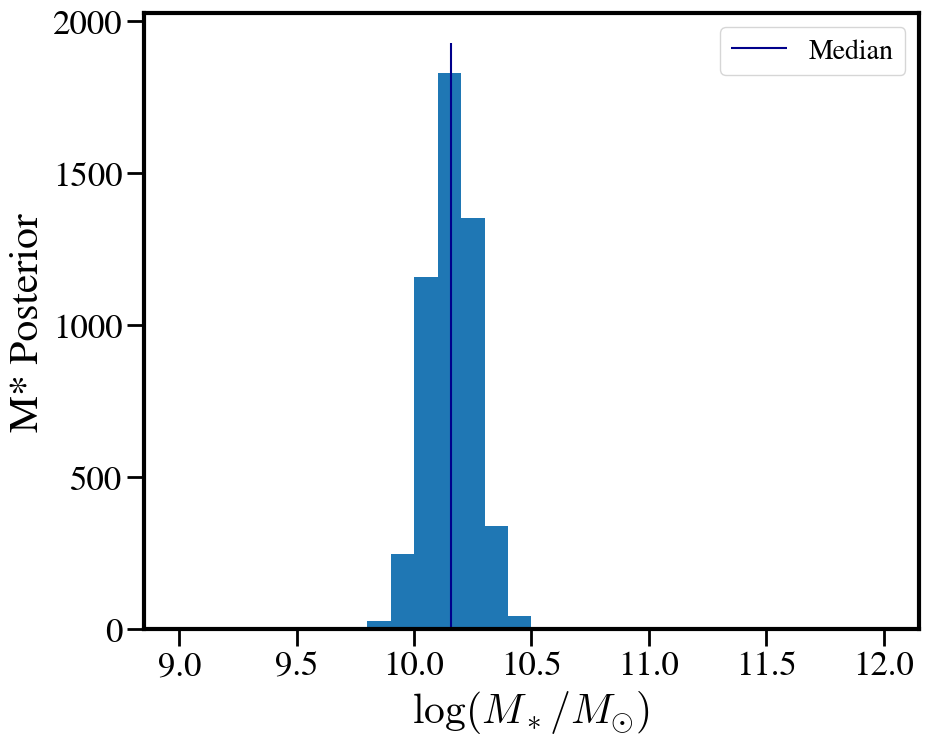

In [89]:
n = plt.hist(np.log10(corrected_stellar_mass_posterior), range=(9, 12), bins=30)
plt.vlines(np.median(np.log10(corrected_stellar_mass_posterior)), ymin=0, ymax=np.max(n[0])+100, color='darkblue', label='Median')
plt.ylabel('M* Posterior')
plt.xlabel('$\log(M_* / M_{\odot})$')
plt.legend()

Now our stellar mass estimate is ~1.4e10, which is really close to the true value of 1.56e10! Only a factor of 1.08 too small. Much better. 


We can again look at the corner plot for this fit, which can give us an idea of how well constrained our galaxy physical properties are and if there are degeneracies in our estimates. Unlike above with the parametric SFH, we unfortunately have to do some prep work to make this plot since the nonparametric model doesn't really return useful into about the SFH. Below I've taken some code from Prospector that will convert the nonparametric SFH parameters into the estimate for recent SFR (over the last 30 Myr)

In [108]:
from prospect.models import transforms
def get_sfr(res, mod):
    agebins = mod.params['agebins']
    thetas = mod.theta_labels()                                                                                                                                           
    agebins_yrs = 10**agebins.T
    dt = agebins_yrs[1, :] - agebins_yrs[0, :]
    zfrac_idx = [i for i, s in enumerate(thetas) if 'z_fraction' in s]
    zfrac_chain = res['chain'][:,zfrac_idx[0]:zfrac_idx[-1]+1]
    
    total_mass_chain = res['chain'][:,thetas.index('logmass')]
    sfr_chain = []
    weights = results.get('weights',None) #likelihood values
    idx = np.argsort(weights)[-5000:]
    for i in idx:
        #this is the important part of this function -- it takes the proxy model parameters we sampled
        # and transforms them into the masses formed in each timebin
        # from there, we just divide these masses by the time in each bin to get the SFR in each bin
        masses_chain = transforms.zfrac_to_masses(10**total_mass_chain[i], zfrac_chain[i], agebins)
        sfr = masses_chain / dt                                                                                                                                  
        sfr_chain.append(sfr[0])                                                                                                                                                
    return sfr_chain

In [109]:
model_sfr = get_sfr(results, model)

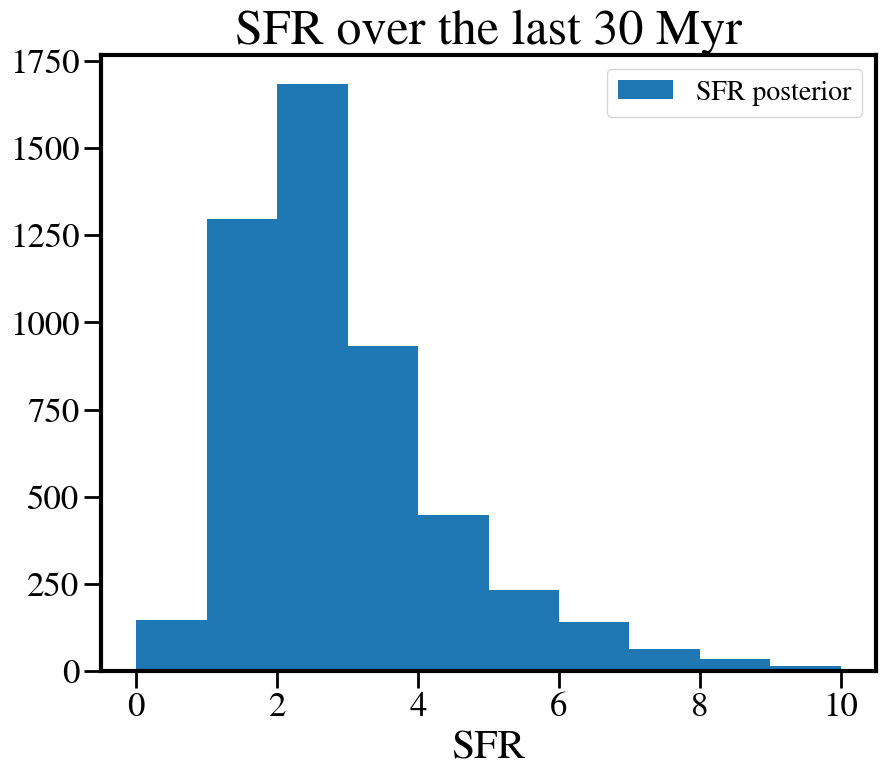

In [110]:
#now plot model SFR histogram

n, _, _ = plt.hist(model_sfr, range=(0,10), label='SFR posterior')
plt.title('SFR over the last 30 Myr')
plt.xlabel('SFR')
plt.legend()

In [127]:
# Now let's contruct the corner plot
import pandas as pd
data = {'log(M$_*$/M$_{\odot}$)\n': np.log10(corrected_stellar_mass_posterior),
       'log(Z$_*$/Z$_{\odot}$)\n': results['chain'][idx,model_params.index('logzsol')],
       'log(SFR)\n': np.log10(model_sfr),
       'A$_V$\n': results['chain'][idx,model_params.index('dust2')]}
        
df = pd.DataFrame(data)

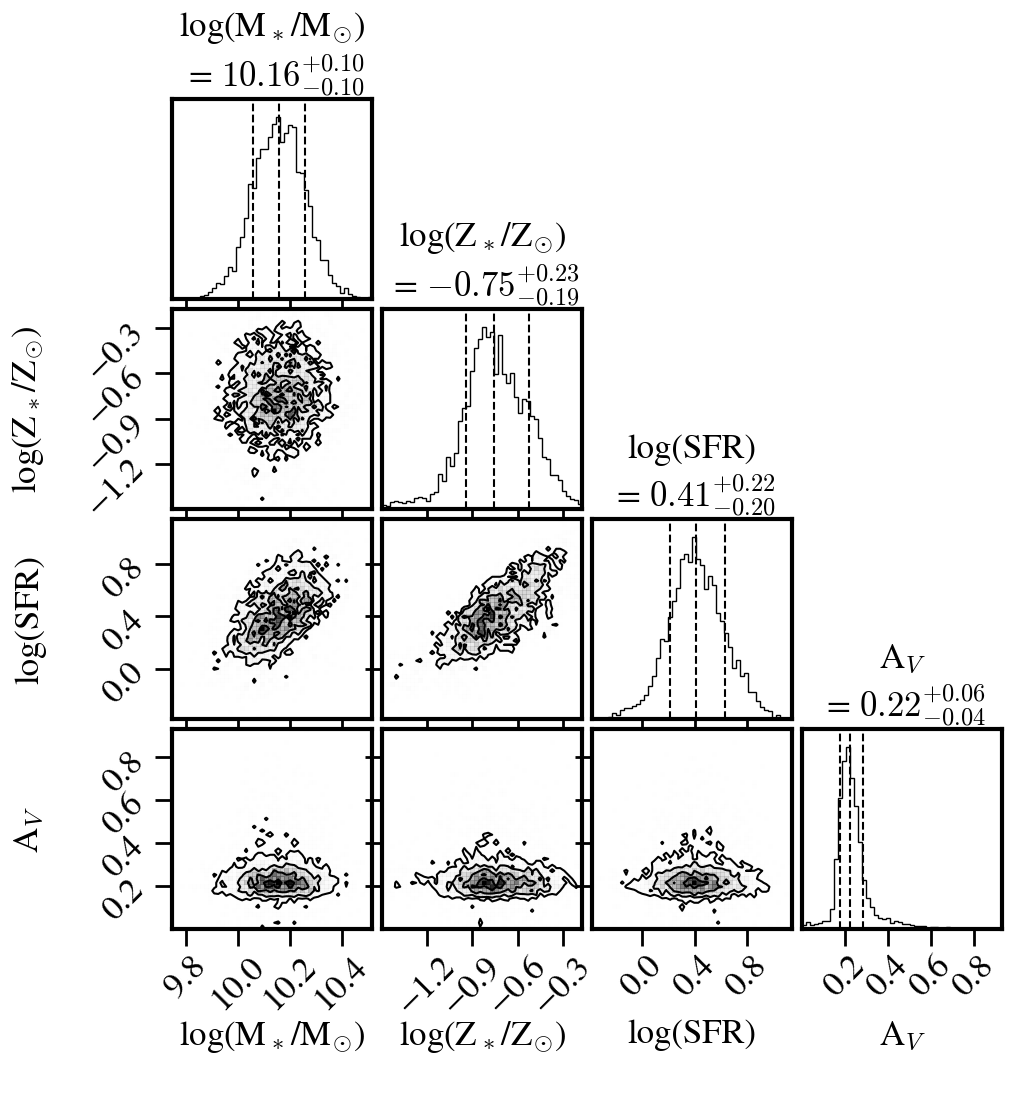

In [128]:
import corner
figure = corner.corner(df,labels=list(data.keys()),
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 25}, label_kwargs={'fontsize': 25}, labelpad=0.15,
                      bins=50,plot_datapoints=False)

## appendix: dealing with units :(

In [145]:
#generate quick FSPS spectra
import fsps
sp = fsps.StellarPopulation(zcontinuous=1, sfh=0, add_dust_emission=True, dust2=0.5)

In [146]:
wav, lum = sp.get_spectrum(tage=5) #wav in Angstrom, lum in Lsun / Hz

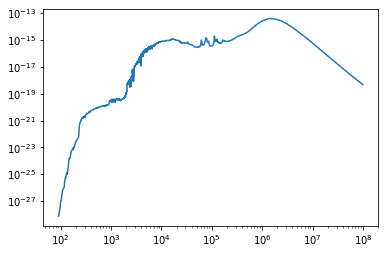

In [147]:
plt.loglog(wav, lum)

FSPS spits out SED units in solar luminosities / Hz for some reason. Not only is this a bit unintuitive, but for use with prospector, which expects SEDs in units of maggies, it's non-trivial to convert. Here's how I've done it:

In [148]:
import astropy.units as u
import astropy.constants as constants

lum = lum * u.Lsun / u.Hz

In [149]:
lum

<Quantity [7.87638705e-29, 1.54538861e-28, 2.50674857e-28, ...,
           5.02541280e-19, 4.89240598e-19, 4.76620348e-19] solLum / Hz>

In [150]:
luminosity_distance = 10 * u.pc #this is obviously arbitrary, meaning our flux will be scaled to whatever distance we put here
#for prospector use, make sure we match 'lumdist' in our model to whatever distance we decide here

lum_cgs = lum.cgs
flux_jansky = (lum_cgs / (4 * np.pi * (luminosity_distance)**2)).to(u.Jy)

In [151]:
flux_jansky

<Quantity [2.51992737e-12, 4.94423018e-12, 8.01995165e-12, ...,
           1.60780256e-02, 1.56524910e-02, 1.52487258e-02] Jy>

In [152]:
#finally, maggies are just a linear scaling of jansky
flux_maggies = flux_jansky.value / 3631.

In [153]:
flux_maggies

array([6.94003683e-16, 1.36167177e-15, 2.20874460e-15, ...,
       4.42798833e-06, 4.31079345e-06, 4.19959399e-06])

Text(0.5, 0, 'Wavelength [$\\AA$]')

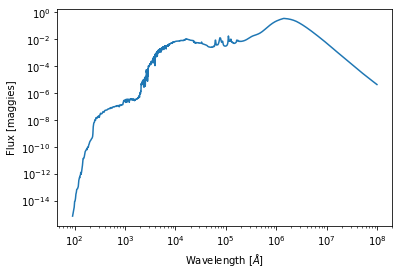

In [154]:
plt.loglog(wav, flux_maggies)
plt.ylabel('Flux [maggies]')
plt.xlabel('Wavelength [$\AA$]')